In [12]:
import os
import numpy as np
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
# import neurokit2 as nk
import pandas as pd
from ecgdetectors import Detectors

In [13]:
# Function that reads a csv file and outputs a data frame
def read_from_csv(file):
    data_frame = pd.read_csv(file, sep=",")
    return data_frame

In [14]:
# Function that writes a data frame to a csv file
def write_to_csv(df, file):
    df.to_csv(index=False)
    location = "C:/Users/riche/Desktop/ECG/"
    path = location + file
    os.makedirs(location, exist_ok=True)  
    df.to_csv(path)

In [15]:
# filtering
def filter_signal(ecg, fs):
    nyq = 0.5*fs
    order=5

    # highpass filter
    high=0.5
    high= high/nyq
    b, a = butter(order, high, 'highpass')
    ecg_h = lfilter(b,a,ecg)

    # lowpass filter
    low = 70
    low= low/nyq
    b, a = butter(order, low, 'lowpass')
    ecg_hl = lfilter(b,a,ecg_h)

    # notch filter
    notch=50
    notch = notch/nyq
    b, a = iirnotch(notch, 30, fs)
    ecg_hln = lfilter(b,a,ecg_hl)

    t=np.arange(0,ecg.size*(1/fs),(1/fs))
    t=t[:ecg.size]

    # plt.figure(figsize=(12,4))
    # plt.plot(t,ecg,label="raw ECG")
    # plt.plot(t,ecg_hln, label="filtered ECG")
    # plt.xlabel('$Time (s)$') 
    # plt.ylabel('$ECG$') 
    # plt.legend()
    return ecg_hln

In [16]:
# detect R-peaks
def detect_rpeaks(fs, ecg_hln):
    detectors = Detectors(fs)

    r_peaks_pan = detectors.pan_tompkins_detector(ecg_hln)
    r_peaks_pan = np.asarray(r_peaks_pan)

    # plt.figure(figsize=(12,4))
    # plt.plot(ecg_hln)
    # plt.plot(r_peaks_pan,ecg_hln[r_peaks_pan], 'ro')
    return r_peaks_pan

# **Feature extraction**

In [20]:
from hrv import HRV   # to import the module

# Feature extraction
def get_features(r_peaks_pan, fs):
    hrv_class = HRV(fs)
    # print(r_peaks_pan)
    #Number of pairs of succesive NNs that differ by more than 20ms(NN20)
    feat_nn20=hrv_class.NN20(r_peaks_pan)
    # print(f"nn20:{feat_nn20}")
    #Number of pairs of succesive NNs that differ by more than 50ms(NN50)
    feat_nn50=hrv_class.NN50(r_peaks_pan)
    # print(f"nn50:{feat_nn50}")
    #Root mean square of succesive differences(RMSSD)
    feat_rmssd=hrv_class.RMSSD(r_peaks_pan, normalise= True)
    # print(f"rmssd:{feat_rmssd}")
    #Heart-rate feature extraction in BPM(HR)
    feat_hr=np.mean(hrv_class.HR(r_peaks_pan))
    # print(f"HR:{feat_hr}")
    #Standard deviation of succesive differences(SDSD)
    feat_sdsd=hrv_class.SDSD(r_peaks_pan)
    # print(f"SDSD:{feat_sdsd}")
    #The proportion of NN50 divided by total number of NNs(pNN50)
    feat_pnn50=hrv_class.pNN50(r_peaks_pan)
    # print(f"pNN50:{feat_pnn50}")
    #The proportion of NN20 divided by total number of NNs(pNN20)
    feat_pnn20=hrv_class.pNN20(r_peaks_pan)
    # print(f"pNN20:{feat_pnn20}")
    #The
    return [feat_nn20, feat_nn50, feat_rmssd, feat_hr, feat_sdsd, feat_pnn50, feat_pnn20]

In [23]:
# set up an empty features file
df_features = pd.DataFrame(None, columns= ['feat_nn20', 'feat_nn50', 'feat_rmssd', 'feat_nnhr', 
                                     'feat_sdsd', 'feat_pnn50', 'feat_pnn20'])
print(df_features)
write_to_csv(df_features, "out_features.csv")


Empty DataFrame
Columns: [feat_nn20, feat_nn50, feat_rmssd, feat_nnhr, feat_sdsd, feat_pnn50, feat_pnn20]
Index: []


In [24]:
# get features from all signals and write to a csv file

fs = 700
y = []
for label in range(1,5):
    file = "out_" + str(label) + ".csv"

    df = read_from_csv(file)

    for subject in df:
        if subject != 'Unnamed: 0':
            y.append(label)
            ecg = df[subject]
            filtered_ecg = filter_signal(ecg, fs)
            r_peaks_pan = detect_rpeaks(fs, filtered_ecg)
            features = get_features(r_peaks_pan, fs)
            df_features.loc[subject+str(label)] = features

write_to_csv(df_features, "out_features.csv")


# **PCA**

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [27]:
df_features.keys()

Index(['feat_nn20', 'feat_nn50', 'feat_rmssd', 'feat_nnhr', 'feat_sdsd',
       'feat_pnn50', 'feat_pnn20'],
      dtype='object')

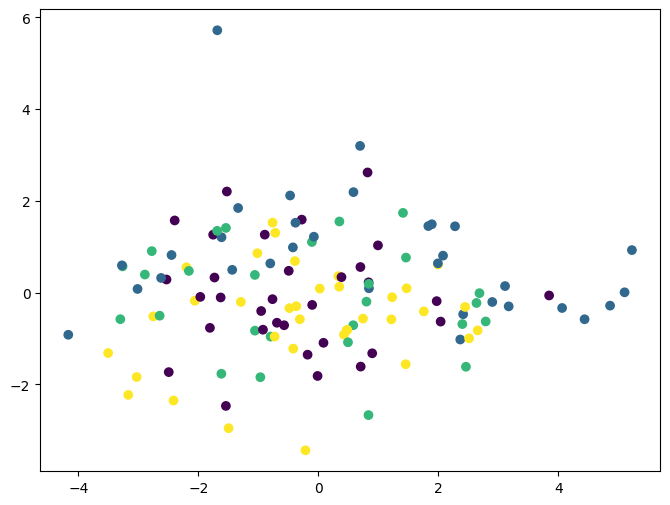

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=3) 
pca = pca.fit(X_train)

X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)

In [29]:
model = LogisticRegression()
model.fit(X_train_pca, y_train)
print(model.score(X_test_pca, y_test))

0.35185185185185186
